In [68]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use('ggplot')

# Datasets
We have two datasets, mat1 and mat2, both consisting of 2 dimensional samples (700, 1400 respectively). We plot these on an 2D plot to examine our data before clustering.

In [59]:
mat1 = scipy.io.loadmat('data1.mat')['X']
mat2 = scipy.io.loadmat('data2.mat')['X']

In [60]:
mat1.shape, mat2.shape

((2, 700), (2, 1400))

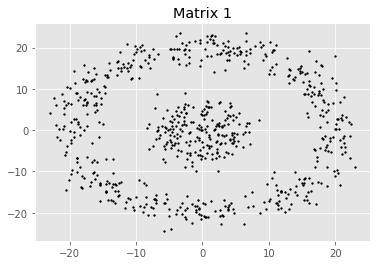

In [64]:
plt.scatter(mat1[0], mat1[1], c='black', s=3)
plt.title('Matrix 1')
plt.show()

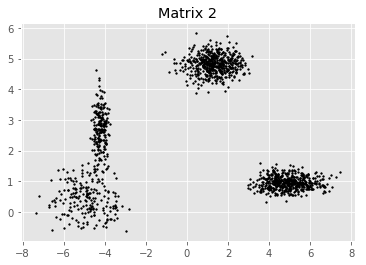

In [63]:
plt.scatter(mat2[0], mat2[1], c='black', s=3)
plt.title('Matrix 2')
plt.show()

# K-Means Clustering
K-means can only separate clusters by linear boundaries

In [312]:
def dist(a, b, ax=1):
    """ Euclidean distance """
    return np.linalg.norm(a-b, axis=ax)

In [ ]:
import copy

# Random centroids
def kmeans(X, k):
    C_x = np.random.randint(0, np.max(X), size=k)
    C_y = np.random.randint(0, np.max(X), size=k)
    C = np.array(list(zip(C_x, C_y)), dtype=np.float32)

    C_old = np.zeros(C.shape)
    clusters = np.zeros(X.shape[1])
    error = dist(C, C_old, None)
    while error != 0:
        for i in range(X.shape[1]):
            distances = dist((X[0][i], X[1][i]), C)
            cluster = np.argmin(distances)
            clusters[i] = cluster
        C_old = copy.deepcopy(C)
        for i in range(k):
            points = [(X[0][j], X[1][j]) for j in range(X.shape[1]) if clusters[j] == i]
            C[i] = np.mean(points, axis=0)
        error = dist(C, C_old, None)
    
    return clusters

In [371]:
# Plot KMeans
def plot_clusters(X, clusters, k, title="Title here"):
    symbols = ['x', 'o', '^', '.', '1', '2', '3', '4']
    fig, ax = plt.subplots()
    for i in range(k):
        points = np.array([(X[0][j], X[1][j]) for j in range(X.shape[1]) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=40, marker=symbols[i])
    plt.title(title)

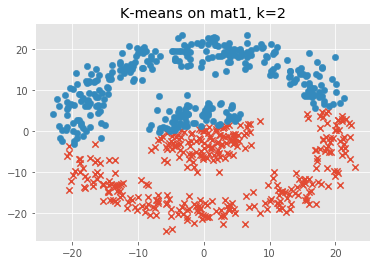

In [378]:
clusters = kmeans(mat1, k=2)
plot_clusters(mat1, clusters, 2, "K-means on mat1, k=2")

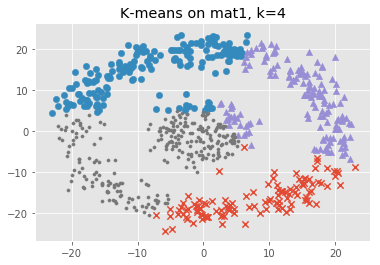

In [379]:
clusters = kmeans(mat1, k=4)
plot_clusters(mat1, clusters, 4, "K-means on mat1, k=4")

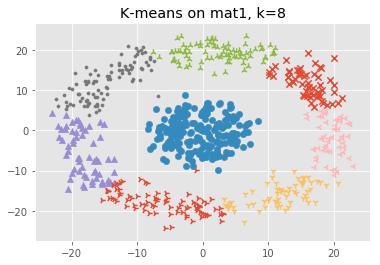

In [394]:
clusters = kmeans(mat1, k=8)
plot_clusters(mat1, clusters, 8, "K-means on mat1, k=8")

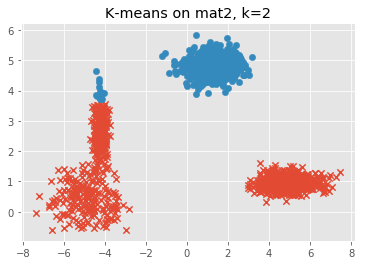

In [389]:
clusters = kmeans(mat2, k=2)
plot_clusters(mat2, clusters, 2, "K-means on mat2, k=2")

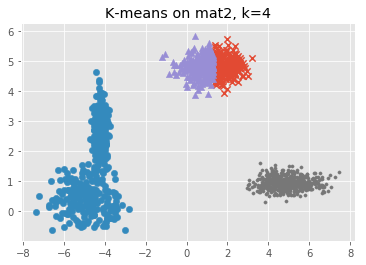

In [390]:
clusters = kmeans(mat2, k=4)
plot_clusters(mat2, clusters, 4, "K-means on mat2, k=4")

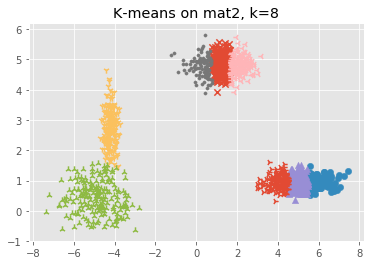

In [400]:
clusters = kmeans(mat2, k=8)
plot_clusters(mat2, clusters, 8, "K-means on mat2, k=8")

# Spectral Clustering

In [396]:
import numpy
import scipy
from sklearn.cluster import KMeans


def laplacian(A):
    """Computes the symetric normalized laplacian.
    L = D^{-1/2} A D{-1/2}
    """
    D = numpy.zeros(A.shape)
    w = numpy.sum(A, axis=0)
    D.flat[::len(w) + 1] = w ** (-0.5)  # set the diag of D to w
    return D.dot(A).dot(D)


def k_means(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1231)
    return kmeans.fit(X).labels_


def spectral_clustering(affinity, n_clusters, cluster_method=k_means):
    L = laplacian(affinity)
    eig_val, eig_vect = scipy.sparse.linalg.eigs(L, n_clusters)
    X = eig_vect.real
    rows_norm = numpy.linalg.norm(X, axis=1, ord=2)
    Y = (X.T / rows_norm).T
    labels = cluster_method(Y, n_clusters)
    return labels